In [1]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset
from torchvision import transforms,utils
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import kagglehub

In [3]:
path = kagglehub.dataset_download("mariaherrerot/ddrdataset")
print("Path to dataset files:", path)

100%|██████████| 2.98G/2.98G [02:23<00:00, 22.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mariaherrerot/ddrdataset/versions/1


In [7]:
list_dir = os.listdir(path)
images_path=os.path.join(path,list_dir[1],list_dir[1])
labels_path=os.path.join(path,list_dir[0])
print(images_path)
print(labels_path)

/root/.cache/kagglehub/datasets/mariaherrerot/ddrdataset/versions/1/DR_grading/DR_grading
/root/.cache/kagglehub/datasets/mariaherrerot/ddrdataset/versions/1/DR_grading.csv


In [8]:
labels_df=pd.read_csv(labels_path)
labels_df.head()

,id_code,diagnosis
0,20170413102628830.jpg,0
1,20170413111955404.jpg,0
2,20170413112015395.jpg,0
3,20170413112017305.jpg,0
4,20170413112528859.jpg,0


<Axes: xlabel='diagnosis', ylabel='count'>

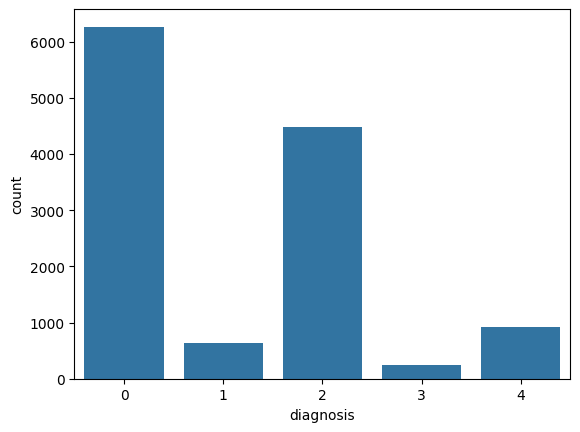

In [9]:
sns.countplot(x='diagnosis',data=labels_df)

In [10]:
train_labels_df,valid_test_labels_df=train_test_split(labels_df,test_size=0.2,random_state=42,shuffle=True,stratify=labels_df['diagnosis'])
valid_labels_df,test_labels_df=train_test_split(valid_test_labels_df,test_size=0.5,random_state=42,shuffle=True,stratify=valid_test_labels_df['diagnosis'])
train_labels_df

,id_code,diagnosis
5127,007-2782-100.jpg,1
2190,007-6101-300.jpg,2
1336,20170429212634742.jpg,0
10302,007-2992-100.jpg,2
2881,20170601083342050.jpg,2
...,...,...
7482,007-1385-000.jpg,0
10825,007-3698-200.jpg,2
4101,20170327160649463.jpg,0
4779,20170409195711766.jpg,0


In [11]:
class DDRDataset(Dataset):
    def __init__(self,images_path,labels, transform=None,mode='rgb_clahe'):
       self.images_path= images_path
       self.labels=labels
       self.transform=transform
       self.mode=mode

    def apply_clahe_rgb(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        return  merged

    def apply_green_clahe(self,image):
      green = image[:, :, 1]
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      green_enhanced = clahe.apply(green)
      return cv2.merge([green_enhanced]*3)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_name=self.labels.iloc[index,0]
        image_path=os.path.join(self.images_path,image_name)
        image=cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        label=int(self.labels.iloc[index,1])
        label=torch.tensor(label).long()
        if self.mode=='rgb_clahe':
            image=self.apply_clahe_rgb(image)
            image=cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        elif self.mode=="lab_clahe":
          image=self.apply_clahe_rgb(image)

        elif self.mode=="green_clahe":
          image=self.apply_green_clahe(image)
        else:
          image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image=self.transform(image)
        else:
            image=transforms.ToTensor()(image)
        return image,label


In [12]:
transforms_train=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=[-180, 180],
                                fill=0,interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])
transforms_test=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataset=DDRDataset(images_path,train_labels_df,transform=transforms_train)
valid_dataset=DDRDataset(images_path,valid_labels_df,transform=transforms_test)
test_dataset=DDRDataset(images_path,test_labels_df,transform=transforms_test)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid_dataset,batch_size=16,shuffle=False)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=16,shuffle=False)

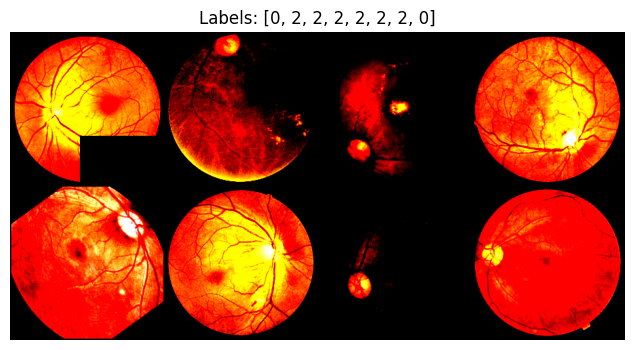

In [14]:
for images, labels in train_loader:
    grid_img =utils.make_grid(images[:8], nrow=4, padding=2)
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()
    np_img = np_img.clip(0, 1)

    plt.figure(figsize=(10, 4))
    plt.imshow(np_img)
    plt.title(f"Labels: {labels[:8].tolist()}")
    plt.axis('off')
    plt.show()
    break

In [15]:
num_classes=5
model=models.mobilenet_v2(pretrained=True)
print(model)
model.classifier[1]=nn.Linear(model.last_channel,num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 212MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [16]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=10, checkpoint_path="mobilenet_dr.pth"):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")


        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = train_correct / total
        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")


        model.eval()
        val_loss = 0.0
        val_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / total
        val_acc = val_correct / total
        print(f"Val Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")


        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint at epoch {epoch+1}")


In [17]:
def test_model(model, test_loader, criterion, device, num_classes=5):
    model.eval()

    accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    precision = Precision(task="multiclass", num_classes=num_classes, average='weighted').to(device)
    recall = Recall(task="multiclass", num_classes=num_classes, average='weighted').to(device)
    f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted').to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(f"Accuracy: {accuracy.compute().item():.4f}")
    print(f"Precision (weighted): {precision.compute().item():.4f}")
    print(f"Recall (weighted): {recall.compute().item():.4f}")
    print(f"F1 Score (weighted): {f1.compute().item():.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=3))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=20)


Epoch [1/20]


100%|██████████| 627/627 [09:10<00:00,  1.14it/s]


Train Loss: 0.7657, Accuracy: 0.7106
Val Loss: 0.6501, Accuracy: 0.7604
Saved checkpoint at epoch 1

Epoch [2/20]


100%|██████████| 627/627 [08:53<00:00,  1.17it/s]


Train Loss: 0.6389, Accuracy: 0.7626
Val Loss: 0.5908, Accuracy: 0.7732
Saved checkpoint at epoch 2

Epoch [3/20]


100%|██████████| 627/627 [08:55<00:00,  1.17it/s]


Train Loss: 0.6028, Accuracy: 0.7770
Val Loss: 0.5594, Accuracy: 0.7907
Saved checkpoint at epoch 3

Epoch [4/20]


100%|██████████| 627/627 [08:53<00:00,  1.18it/s]


Train Loss: 0.5622, Accuracy: 0.7994
Val Loss: 0.6064, Accuracy: 0.7875

Epoch [5/20]


100%|██████████| 627/627 [08:50<00:00,  1.18it/s]


Train Loss: 0.5458, Accuracy: 0.8068
Val Loss: 0.5050, Accuracy: 0.8235
Saved checkpoint at epoch 5

Epoch [6/20]


100%|██████████| 627/627 [08:53<00:00,  1.18it/s]


Train Loss: 0.5123, Accuracy: 0.8129
Val Loss: 0.5848, Accuracy: 0.7875

Epoch [7/20]


100%|██████████| 627/627 [08:53<00:00,  1.18it/s]


Train Loss: 0.4934, Accuracy: 0.8209
Val Loss: 0.5041, Accuracy: 0.8283
Saved checkpoint at epoch 7

Epoch [8/20]


100%|██████████| 627/627 [08:52<00:00,  1.18it/s]


Train Loss: 0.4812, Accuracy: 0.8279
Val Loss: 0.5373, Accuracy: 0.8219

Epoch [9/20]


100%|██████████| 627/627 [08:54<00:00,  1.17it/s]


Train Loss: 0.4765, Accuracy: 0.8292
Val Loss: 0.4678, Accuracy: 0.8363
Saved checkpoint at epoch 9

Epoch [10/20]


100%|██████████| 627/627 [08:53<00:00,  1.18it/s]


Train Loss: 0.4529, Accuracy: 0.8376
Val Loss: 0.4894, Accuracy: 0.8307

Epoch [11/20]


100%|██████████| 627/627 [08:49<00:00,  1.18it/s]


Train Loss: 0.4550, Accuracy: 0.8354
Val Loss: 0.4878, Accuracy: 0.8323

Epoch [12/20]


100%|██████████| 627/627 [08:48<00:00,  1.19it/s]


Train Loss: 0.4439, Accuracy: 0.8391
Val Loss: 0.4540, Accuracy: 0.8363
Saved checkpoint at epoch 12

Epoch [13/20]


100%|██████████| 627/627 [08:44<00:00,  1.20it/s]


Train Loss: 0.4343, Accuracy: 0.8455
Val Loss: 0.4947, Accuracy: 0.8331

Epoch [14/20]


100%|██████████| 627/627 [08:41<00:00,  1.20it/s]


Train Loss: 0.4248, Accuracy: 0.8461
Val Loss: 0.4511, Accuracy: 0.8355
Saved checkpoint at epoch 14

Epoch [15/20]


100%|██████████| 627/627 [08:42<00:00,  1.20it/s]


Train Loss: 0.4116, Accuracy: 0.8518
Val Loss: 0.4177, Accuracy: 0.8602
Saved checkpoint at epoch 15

Epoch [16/20]


100%|██████████| 627/627 [08:43<00:00,  1.20it/s]


Train Loss: 0.4044, Accuracy: 0.8523
Val Loss: 0.4950, Accuracy: 0.8339

Epoch [17/20]


100%|██████████| 627/627 [08:42<00:00,  1.20it/s]


Train Loss: 0.3929, Accuracy: 0.8584
Val Loss: 0.4712, Accuracy: 0.8458

Epoch [18/20]


100%|██████████| 627/627 [08:38<00:00,  1.21it/s]


Train Loss: 0.3873, Accuracy: 0.8578
Val Loss: 0.4279, Accuracy: 0.8458

Epoch [19/20]


100%|██████████| 627/627 [08:44<00:00,  1.20it/s]


Train Loss: 0.3813, Accuracy: 0.8617
Val Loss: 0.4535, Accuracy: 0.8442

Epoch [20/20]


100%|██████████| 627/627 [08:46<00:00,  1.19it/s]


Train Loss: 0.3705, Accuracy: 0.8645
Val Loss: 0.5612, Accuracy: 0.8267


100%|██████████| 79/79 [00:56<00:00,  1.40it/s]


Accuracy: 0.8492
Precision (weighted): 0.8481
Recall (weighted): 0.8492
F1 Score (weighted): 0.8325

Classification Report:
              precision    recall  f1-score   support

           0      0.854     0.955     0.902       627
           1      0.778     0.111     0.194        63
           2      0.824     0.846     0.835       448
           3      0.846     0.478     0.611        23
           4      0.971     0.739     0.840        92

    accuracy                          0.849      1253
   macro avg      0.855     0.626     0.676      1253
weighted avg      0.848     0.849     0.833      1253



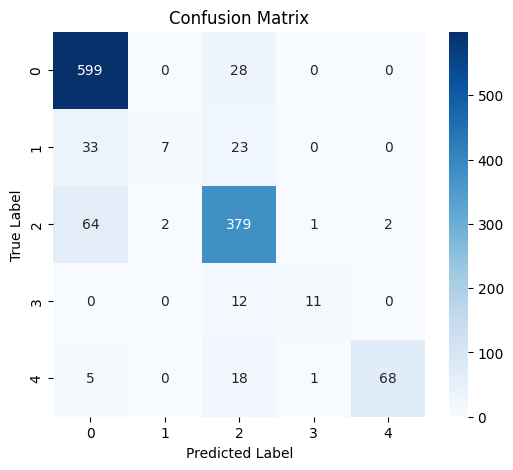

In [19]:
model.load_state_dict(torch.load("mobilenet_dr.pth"))
test_model(model, test_loader, criterion, device)